# Useful references

## Python + Numpy + Matplotlib + etc.

* Python Numpy Tutorial: http://cs231n.github.io/python-numpy-tutorial/
* Computational Statistics in Python: https://people.duke.edu/~ccc14/sta-663/
* Numpy for MATLAB users: https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html
* MATLAB synonymous commands in Python/NumPy: http://mathesaurus.sourceforge.net/

## NEURON (with Python)
* NEURON documentation: https://www.neuron.yale.edu/neuron/static/py_doc/index.html
* NEURON + Python tutorial: https://neuron.yale.edu/neuron/static/docs/neuronpython/index.html

## NMODL
* NEURON Extension to NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl2.html
* NMODL: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/nmodl.html#nmodl




# 1. Morris-Lecar neuron

Here we demonstrate how to compile custom active mechanisms. Most models of membrane/intracellular mechanisms are written in the NMODL language and the files should have an extension ".mod". In order to use those mod files (therefore active mechanisms), you first need to compile them, and, if necessary, direct NEURON to load the compiled library.

Here our first example is `MorrisLecar.mod`, which implements the Morris-Lecar ion channels, used in Rinzel and Ermentrout. If you look into the file, it looks like:

```
TITLE Morris-Lecar spiking dynamics

....

NEURON {
  SUFFIX ml
  USEION k READ ek WRITE ik
  USEION na READ ena WRITE ina
  NONSPECIFIC_CURRENT il
  RANGE gnabar, gkbar, gleak, el, ina, ik, il, w, winit
  RANGE phi, betam, gammam, betaw, gammaw
  THREADSAFE minf, winf, tauw
}

.....

```

The first part contains important information: `ml`, after `SUFFIX`, is the name of this mechanism in NEURON, just as `pas` and `hh` that we have seen before. `USEION` tells you which ions are used. In particular, it writes `ik` and `ina`, which correspond to the K+ and Na+ current. `RANGE` specifies the variables that you can read and write in NEURON.

To compile this, run `nrnivmodl` in the terminal or simply 

In [1]:
%%bash

nrnivmodl

Creating x86_64 directory for .o files.

/root/Documents/tutorial_3
MorrisLecar.mod
MorrisLecar.mod
"/usr/local/nrn/x86_64/bin/nocmodl" MorrisLecar
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o MorrisLecar.lo MorrisLecar.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -O3 -fPIC -fno-strict-aliasing -msse3 -c MorrisLecar.c  -fPIC -DPIC -o .libs/MorrisLecar.o
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o mod_func.lo mod_func.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -O3 -fPIC -fno-strict-aliasing -msse3 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/usr/lo

Translating MorrisLecar.mod into MorrisLecar.c
Thread Safe
[19f9e25f963d:01489] Error: Unable to get the current working directory


Note that a directory `x86_64` is created. NEURON will automatically recognize this and load the mechanism.

In [2]:
from neuron import h, gui

Now let's create a neuron with this mechanism

In [3]:
soma = h.Section(name="soma")
soma.L = 15
soma.diam = 15
soma.insert('ml')

# Inspect this soma
h.psection()

soma { nseg=1  L=15  Ra=35.4
	/*location 0 attached to cell 0*/
	/* First segment only */
	insert morphology { diam=15}
	insert capacitance { cm=1}
	insert ml { gnabar_ml=0.02 gkbar_ml=0.02 gleak_ml=0.002 el_ml=-70 phi_ml=0.15 betam_ml=-1.2 gammam_ml=18 betaw_ml=0 gammaw_ml=10 winit_ml=0}
	insert k_ion { ek=-77}
	insert na_ion { ena=50}
}


1.0

Note parameters that we have seen in the `RANGE` part of the MOD files. Now let's append a current clamp to excite this cell and run a simulation:

In [4]:
ic = h.IClamp(soma(0.5))
ic.delay = 50
ic.dur = 200
ic.amp = 0.26 # 260pA injection for 200ms

In [5]:
dt = 0.1 # 10kHz sampling rate
def run():
    vrec = h.Vector()
    vrec.record(soma(0.5)._ref_v, dt)
    
    h.tstop = 250
    h.init()
    h.run()
    
    return vrec.c()

import numpy as np
import matplotlib.pyplot as plt
def plot_result(vrec):
    fig, ax = plt.subplots()
    t = np.arange(vrec.size())*dt
    ax.plot(t, vrec)    

<IPython.core.display.Javascript object>


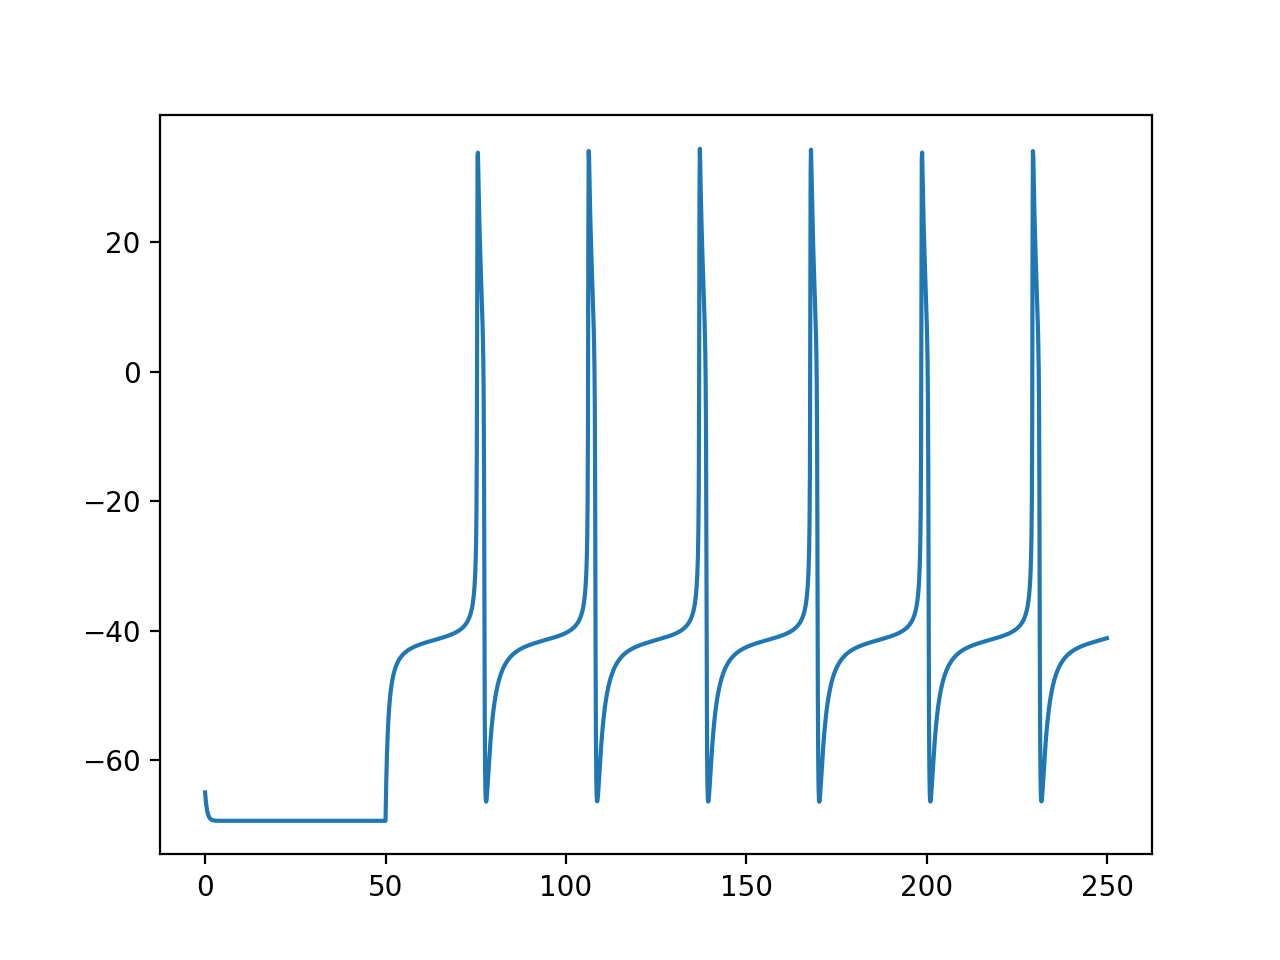

In [6]:
%matplotlib nbagg

vrec = run()
plot_result(vrec)

Further down in the `MorrisLecar.mod`, we find

```
...

STATE {
  m   FROM 0 TO 1
  w   FROM 0 TO 1
}

INITIAL {
	rates(v)
	m = minf
	w = winit
}

BREAKPOINT {
  SOLVE states METHOD cnexp
  gna = gnabar * m
  gk  = gkbar * w
  ik  = gk * (v - ek)
  ina = gna * (v - ena)
  il  = gleak * (v - el)
}

...

```

Here you can see `m` and `w` are the gating variables for the Na+ and K+ channel. We can modify our run function to record these as well:


In [7]:
dt = 0.1 # 10kHz sampling rate
def run():
    vrec, mrec, wrec = h.Vector(), h.Vector(), h.Vector()
    vrec.record(soma(0.5)._ref_v, dt)
    mrec.record(soma(0.5)._ref_m_ml, dt) #Note _ml
    wrec.record(soma(0.5)._ref_w_ml, dt) #Note _ml as well
    
    h.tstop = 250
    h.init()
    h.run()
    
    return (vrec.c(), mrec.c(), wrec.c())

<IPython.core.display.Javascript object>


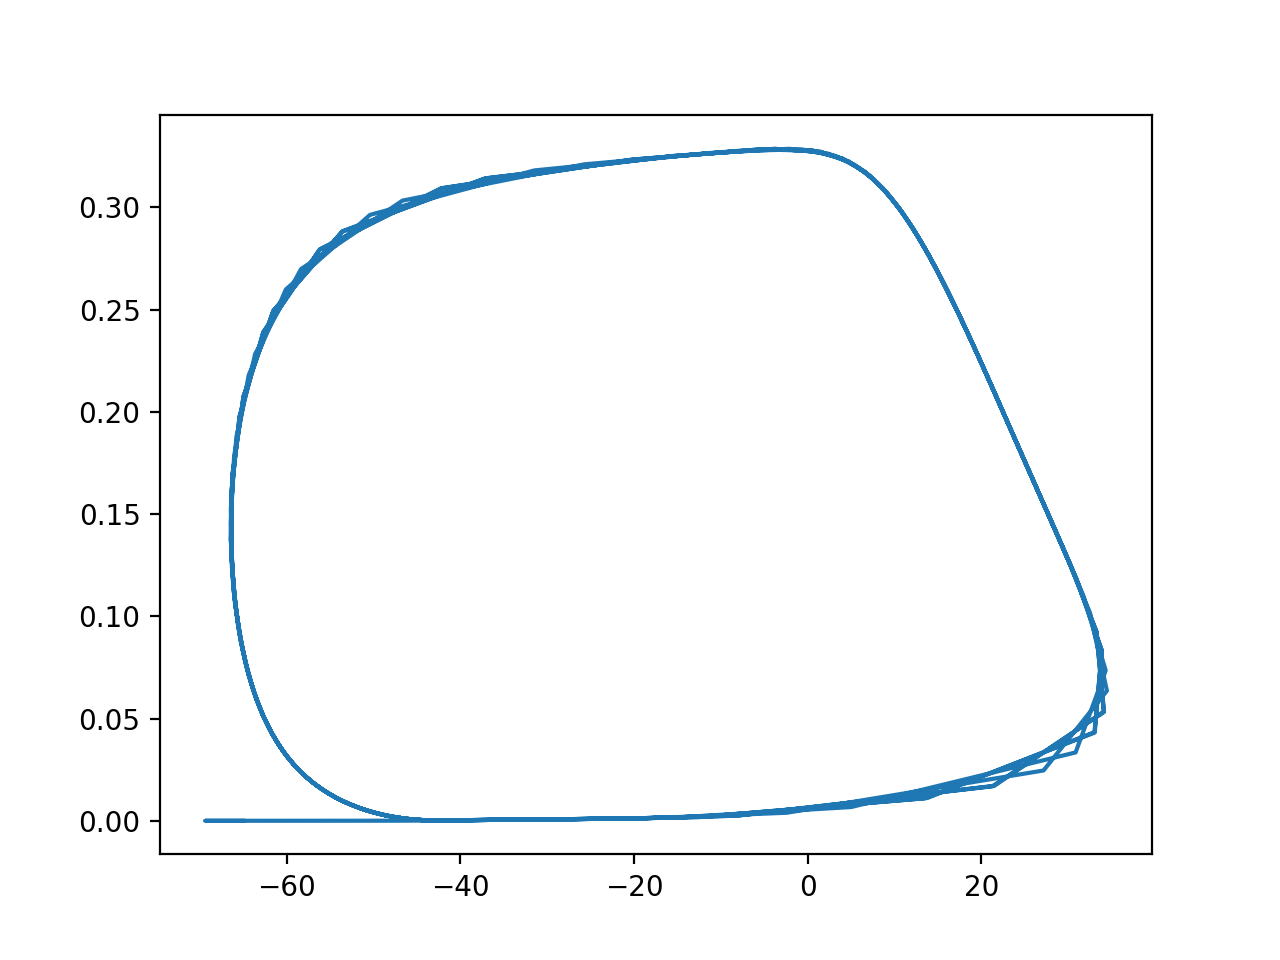

In [8]:
v, m, w = run()

fig, ax = plt.subplots()
ax.plot(v, w)

# 2. Voltage clamp experiment

Here we show how to use the voltage clamp for probing the I-V relationship due to the active channels. We use the [`SEClamp`](https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html?highlight=seclamp#SEClamp) for this.

In [9]:
vc = h.SEClamp(soma(0.5))

# Then we turn off the current clamp
ic.amp = 0

In [10]:
vc.dur1 = 50
vc.dur2 = 150
vc.dur3 = 50

vc.amp1 = -70
vc.amp2 = -10
vc.amp3 = -70

<IPython.core.display.Javascript object>


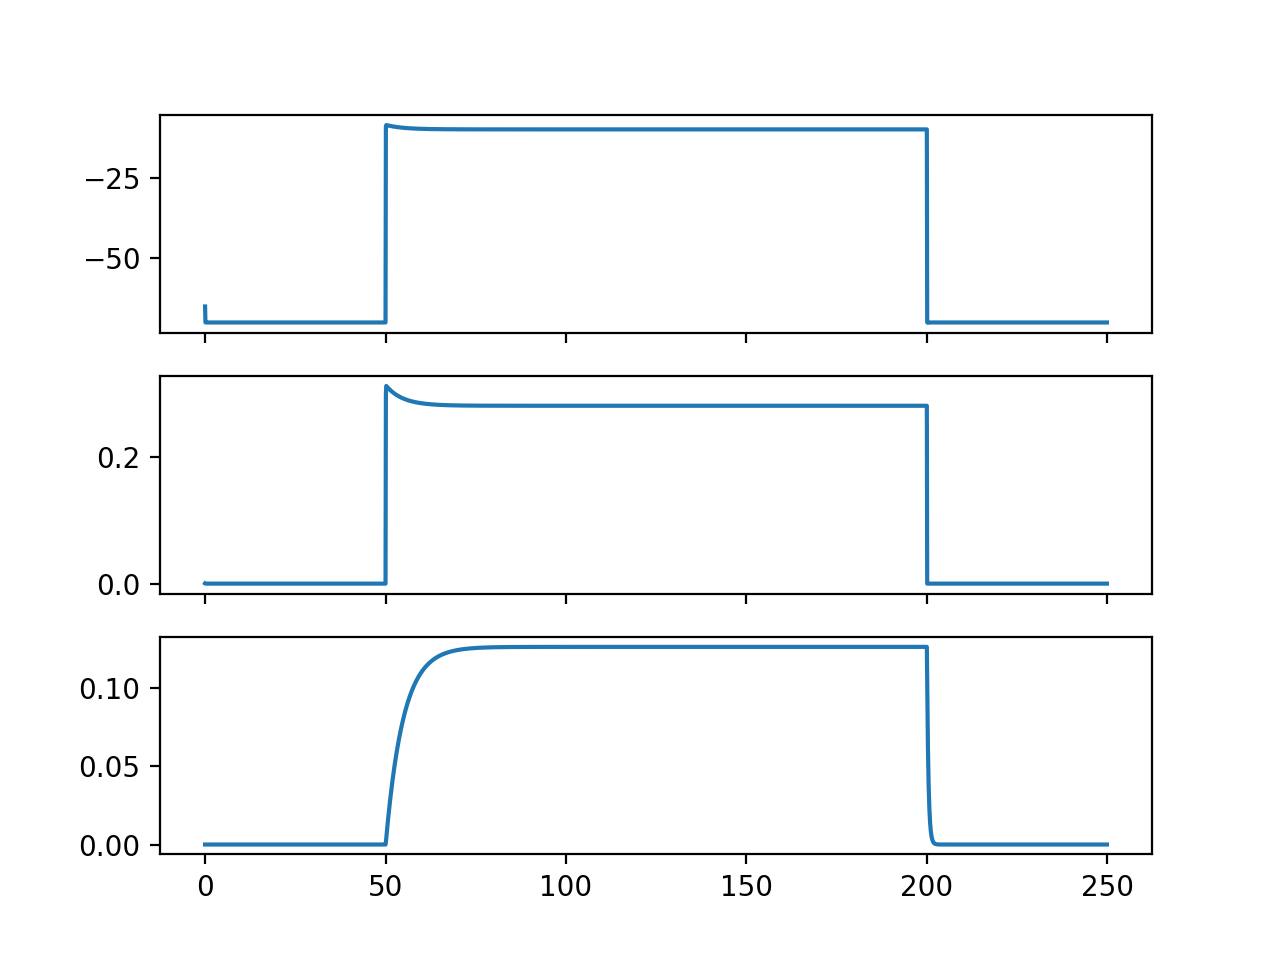

In [11]:
v, m, w = run()

fig, ax = plt.subplots(nrows=3, sharex=True)
t = np.arange(v.size())*dt
ax[0].plot(t, v)
ax[1].plot(t, m)
ax[2].plot(t, w)

# 3. More complex models

Here we demonstrate how much more complex models are organized and run. Our example is the simulation in Branco et al., 2010, which can be downloaded at https://senselab.med.yale.edu/modeldb/ShowModel.cshtml?model=140828. Opening the zip file, we can see the mod files are all in `mod.files` directory. Again, we compile those and run NEURON **after restarting the kernel**:

In [1]:
%%bash
cd Branco_2010/mod.files
nrnivmodl

Creating x86_64 directory for .o files.

/root/Documents/tutorial_3/Branco_2010/mod.files
CaT.mod HH2.mod NMDA_Mg_T.mod ar.mod ca.mod caL3d.mod cad.mod h.mod inwardrect.mod kca.mod kir.mod km.mod kv.mod na.mod release_BMK.mod
CaT.mod HH2.mod NMDA_Mg_T.mod ar.mod ca.mod caL3d.mod cad.mod h.mod inwardrect.mod kca.mod kir.mod km.mod kv.mod na.mod release_BMK.mod
"/usr/local/nrn/x86_64/bin/nocmodl" CaT
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -fPIC -fno-strict-aliasing -msse3 -c -o CaT.lo CaT.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/usr/local/nrn/include/nrn -I/usr/local/nrn/x86_64/lib -O3 -fPIC -fno-strict-aliasing -msse3 -c CaT.c  -fPIC -DPIC -o .libs/CaT.o
"/usr/local/nrn/x86_64/bin/nocmodl" HH2
"/usr/local/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/usr/local/nrn/include/nrn" -I"/usr/local/nrn/x86_64/lib"      -O3 -

Translating CaT.mod into CaT.c
Notice: VERBATIM blocks are not thread safe
Notice: This mechanism cannot be used with CVODE
Translating HH2.mod into HH2.c
Notice: VERBATIM blocks are not thread safe
Notice: This mechanism cannot be used with CVODE
Translating NMDA_Mg_T.mod into NMDA_Mg_T.c
Notice: Use of POINTER is not thread safe.
NEURON's CVode method ignores conservation
Notice: Assignment to the GLOBAL variable, "rmd2u", is not thread safe
Notice: Assignment to the GLOBAL variable, "rmd2b", is not thread safe
Notice: Assignment to the GLOBAL variable, "rmd1u", is not thread safe
Notice: Assignment to the GLOBAL variable, "rmd1b", is not thread safe
Translating ar.mod into ar.c
Thread Safe
Translating ca.mod into ca.c
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
Translating caL3d.mod into caL3d.c
NEURON's CVode method ignores conservation
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
Translating cad.mod into cad.c
Thread Safe
Translat

Then, we direct neuron to load mechanisms from this directory as:

In [2]:
import neuron
neuron.load_mechanisms("Branco_2010/mod.files")
from neuron import h, gui

Now the main simulation should run without a problem.

In [3]:
h.load_file("Branco_2010/mosinit.hoc")

	1 
	1 
	1 
	1 
	0 
	1 
0 
1 
2 
3 
4 
5 
6 
7 
8 
	1 
	0 
	1 
0 
1 
	1 
	1 
	0 
	0 
	0 
	0 
	1 


1.0